<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/plan/plan5a_Multi_Layer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

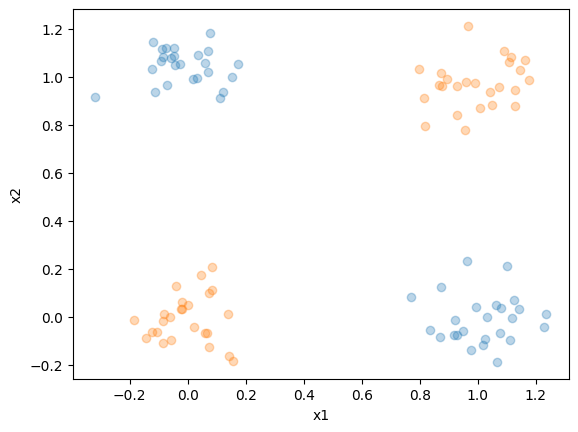

In [174]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

def sign(a):
  return (a>0) * 2 - 1

def criaDataset(n=100, func=lambda a, b: bool(a) != bool(b)):
  X, y = make_blobs(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1)
  y = sign(np.array([func(x[0]>0.5, x[1]>0.5) for x in X], dtype=int))
  return X, y

X, y = criaDataset()

def plotDataset(X, y):
  plt.xlabel("x1")
  plt.ylabel("x2")
  for k in set(y):
    plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotDataset(X, y)

In [175]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

In [176]:
def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [177]:
from scipy.special import expit

def tanh(a):
  return expit(a)*2-1

1.0

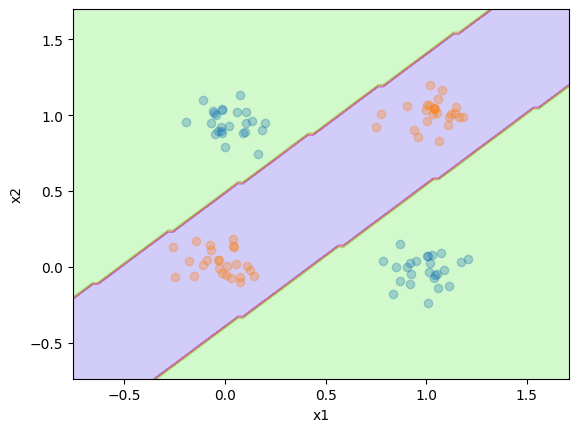

In [178]:
X, y = criaDataset()
plotDataset(X, y)

class SingleHiddenLayer(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.005):
    self.max_iter = max_iter
    self.learning_rate = learning_rate

  def forward(self, X):
    self.pH = X @ self.ihw
    self.H = tanh(self.pH)
    self.Hb = include_bias(self.H)
    return self.Hb @ self.how

  def backward(self, X, y, ypred):
    ho_delta = y.reshape(-1,1) - ypred.reshape(-1,1)
    ho_grad = self.Hb.T @ ho_delta
    ### PULO DO GATO ###
    tanh_grad = (1 - np.square(self.H))
    ih_delta = (ho_delta @ self.how[1:,:].T) * tanh_grad
    ### #### ## #### ###
    ih_grad = X.T @ ih_delta
    self.how += ho_grad * self.learning_rate
    self.ihw += ih_grad * self.learning_rate

  def fit(self, X, y):
    Xb = include_bias(X)
    self.ihw = np.random.uniform(-1, 1, size=(Xb.shape[1], 2))
    self.how = np.random.uniform(-1, 1, size=(2+1, 1))
    for _ in range(self.max_iter):
      ypred = self.forward(Xb)
      self.backward(Xb, y, ypred)

  def predict(self, X):
    Xb = include_bias(X)
    self.pH = Xb @ self.ihw
    self.H = tanh(self.pH)
    Hb = include_bias(self.H)
    return sign(Hb @ self.how)

clf = SingleHiddenLayer()
clf.fit(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

1.0

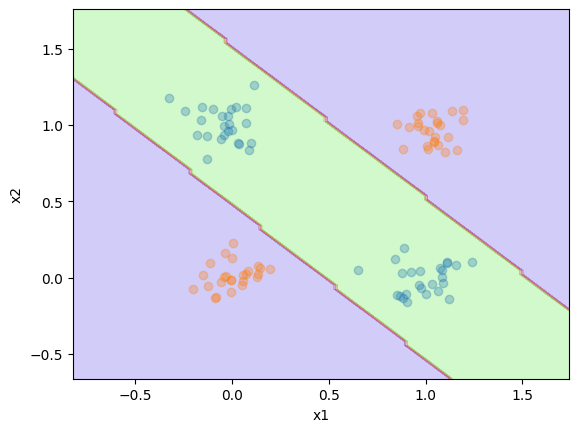

In [179]:
X, y = criaDataset()
plotDataset(X, y)

class Backpropagation(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.005):
    self.max_iter = max_iter
    self.learning_rate = learning_rate

  def forward(self, X):
    Xb = include_bias(X)
    self.pH = Xb @ self.ihw
    self.H = tanh(self.pH)
    self.Hb = include_bias(self.H)
    return self.Hb @ self.how

  def backward(self, X, y, ypred):
    ho_delta = y.reshape(-1,1) - ypred.reshape(-1,1)
    ho_grad = self.Hb.T @ ho_delta
    ### PULO DO GATO ###
    tanh_grad = (1 - np.square(self.H))
    ih_delta = (ho_delta @ self.how[1:,:].T) * tanh_grad
    ### #### ## #### ###
    Xb = include_bias(X)
    ih_grad = Xb.T @ ih_delta
    self.how += ho_grad * self.learning_rate
    self.ihw += ih_grad * self.learning_rate

  def fit(self, X, y):
    self.ihw = np.random.uniform(-1, 1, size=(X.shape[1]+1, 2))
    self.how = np.random.uniform(-1, 1, size=(2+1, 1))
    for _ in range(self.max_iter):
      ypred = self.forward(X)
      self.backward(X, y, ypred)

  def predict(self, X):
    return sign(self.forward(X))

clf = Backpropagation()
clf.fit(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

1.0

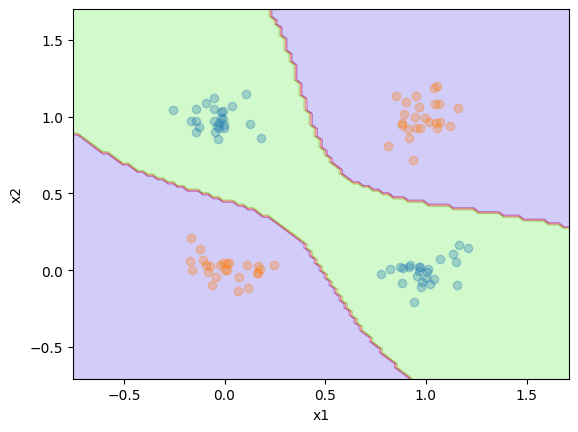

In [180]:
X, y = criaDataset()
plotDataset(X, y)

class Backpropagation(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.005, n_hidden=[2]):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden

  def forward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = tanh(self.Z[-1])
    return AUX

  def backward(self, X, y, ypred):
    grads = []
    output_delta = y.reshape(-1,1) - ypred.reshape(-1,1)
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      tanh_grad = (1 - np.square(tanh(self.Z[i-1])))
      input_delta = (output_delta @ self.Ws[i][1:,:].T) * tanh_grad
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()
    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] += grads[i] * self.learning_rate

  def fit(self, X, y):
    self.Ws = []
    previous_output = X.shape[1]
    for layer_size in self.n_hidden:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
      previous_output = self.Ws[-1].shape[1]
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, 1)))
    for _ in range(self.max_iter):
      ypred = self.forward(X)
      self.backward(X, y, ypred)

  def predict(self, X):
    return sign(self.forward(X))

clf = Backpropagation(n_hidden=[10, 5])
clf.fit(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

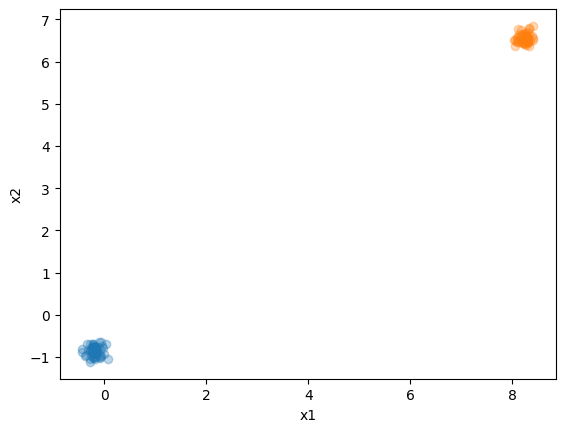

In [183]:
from sklearn.preprocessing import normalize

def criaDatasetDificil(n=100, centros=2):
  X, y = make_blobs(n_samples=n, centers=centros, cluster_std=0.1)
  y = sign(np.array(y%2, dtype=int))
  return X, y

X, y = criaDatasetDificil()

plotDataset(X, y)

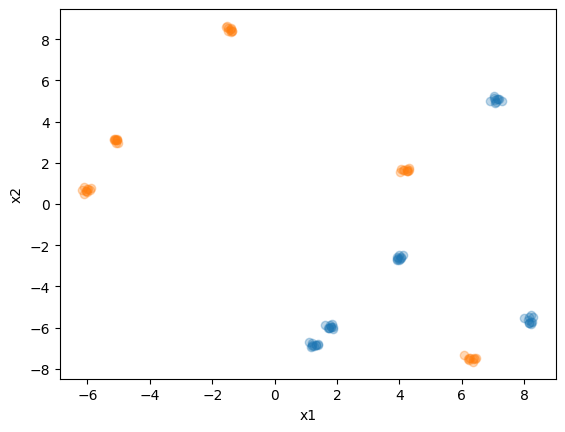

In [184]:
X, y = criaDatasetDificil(centros=10)
plotDataset(X, y)

1.0

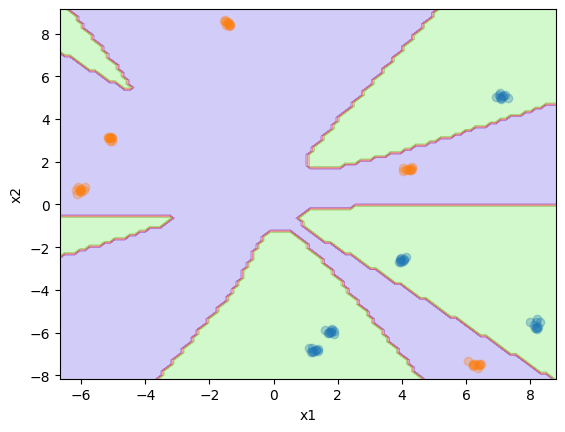

In [185]:
plotDataset(X, y)
clf = Backpropagation(n_hidden=[10, 10])
clf.fit(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)